In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
%matplotlib inline

In [3]:
np.random.seed(42)

# Load train and test data

In [4]:
# assume mnist-original.mat is in the working directory
mnist = loadmat("mnist-original.mat")

In [5]:
X,y = (np.array(mnist["data"]).T, np.array(mnist["label"]))

In [6]:
Xtrain0, ytrain0 = X[:60000,:], y[0,:60000]
Xtest, ytest = X[60000:,:], y[0,60000:]

In [7]:
# shuffle the training set
shuffle_index = np.random.permutation(60000)
Xtrain1, ytrain1 = Xtrain0[shuffle_index,:],ytrain0[shuffle_index]

In [8]:
Xtrain,ytrain = Xtrain1[:48000,:], ytrain1[:48000]
Xval,yval = Xtrain1[48000:,:], ytrain1[48000:]

Label: 2


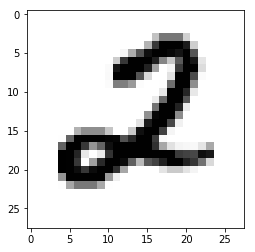

In [9]:
# test that the code is working
some_index=13286
print("Label: {:.0f}".format(ytrain[some_index]))
plt.imshow(Xtrain[some_index].reshape(28,28),
           cmap=matplotlib.cm.binary,interpolation="nearest")

# PCA

In [10]:
pca = PCA(n_components=100).fit(Xtrain)

In [11]:
V=pca.inverse_transform(pca.transform([Xtrain[some_index]]))

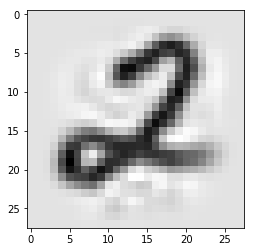

In [12]:
plt.imshow(V.reshape(28,28),
           cmap=matplotlib.cm.binary,interpolation="nearest")

# SGDClassifier

In [13]:
sgdclf = SGDClassifier(loss="hinge",alpha=0.0001,n_jobs=-1,tol=1e-3,max_iter=1000)

In [14]:
sgdclf.fit(Xtrain,ytrain)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
print("Training set score: {0:.4f}".format(sgdclf.score(Xtrain,ytrain)))

Training set score: 0.8321


In [35]:
print("Validation set score: {0:.4f}".format(sgdclf.score(Xval,yval)))

Validation set score: 0.8843


# RandomForestClassifier

In [17]:
forestclf = RandomForestClassifier(n_estimators=75,n_jobs=-1)

In [18]:
forestclf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
print("Training set score: {0:.4f}".format(forestclf.score(Xtrain,ytrain)))

Training set score: 0.9536


In [33]:
print("Validation set score: {0:.4f}".format(forestclf.score(Xval,yval)))

Validation set score: 0.9661


# RandomForestClassifier with expanded training data

Expand the training data to include all one-pixel shifts (left, right, up, down) of each image in <tt>Xtrain</tt>.

In [21]:
def shiftlr(im,numpixels,fill_value):
    blank = 0*im+fill_value
    index0 = im.shape[1]
    index1 = 2*im.shape[1]
    bigim = np.append(np.append(blank,im,axis=1),blank,axis=1)
    return bigim[:,index0+numpixels:index1+numpixels]

def shiftud(im,numpixels,fill_value):
    return shiftlr(im.T,numpixels,fill_value).T

maxindex = Xtrain.shape[0]
for i in range(maxindex):
    im0 = Xtrain[i].reshape(28,28)
    im1 = shiftlr(im0,1,0).reshape(784)
    im2 = shiftlr(im0,-1,0).reshape(784)
    im3 = shiftud(im0,1,0).reshape(784)
    im4 = shiftud(im0,-1,0).reshape(784)
    ytrain = np.append(ytrain,[ytrain[i],ytrain[i],ytrain[i],ytrain[i]],axis=0)
    Xtrain = np.append(Xtrain,[im1,im2,im3,im4],axis=0)
    if (i%1000 == 0):
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000


In [25]:
forest_ext_clf = RandomForestClassifier(n_estimators=75,n_jobs=-1)

In [27]:
forest_ext_clf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
print("Training set score: {0:.4f}".format(forest_ext_clf.score(Xtrain,ytrain)))

Training set score: 1.0000


In [30]:
print("Validation set score: {0:.4f}".format(forest_ext_clf.score(Xval,yval)))

Validation set score: 0.9778


# Performance on the test set

So far we have only been working on the training and validation sets. The data suggests that the <tt>RandomForestClassifier</tt> trained on the <em>expanded training set</em> (consisting of the original training set plus one-pixel shifts in all four directions) has the best performance, with 97.8% accuracy on the validation set. Note that the data is fairly well-balanced between the digits 0 through 9, so the accuracy can be considered meaningful in this context.

Let us now check whether the <tt>RandomForestClassifier</tt> trained on the expanded training set performs well on the test set (which we have not touched til now).

In [36]:
print("Test set score: {0:.4f}".format(forest_ext_clf.score(Xtest,ytest)))

Test set score: 0.9794


The model performs slightly better on the test set than on the validation set.